In [595]:
!pip install pandas yfinance matplotlib seaborn
import yfinance as yf
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

In [790]:
tickers = [
    "AAPL", "MSFT", "JPM", "V", "JNJ", "WMT", "PG", "UNH", "DIS", "HD",
    "INTC", "MRK", "KO", "PEP", "VZ", "NKE", "MCD", "IBM", "AXP", "BA",
    "CAT", "GS", "MMM", "TRV", "WBA", "CSCO", "XOM", "CVX", "RTX", "DOW"
]

In [792]:
all_data_frames=[]

In [794]:
for ticker in tickers:
    company_data = yf.download(ticker, start='2000-01-01', end=datetime.today().strftime('%Y-%m-%d'))
    company = yf.Ticker(ticker)
    outstanding_shares = company.info.get('sharesOutstanding')
    company_data['Market Cap'] = company_data['Close'] * outstanding_shares
    company_data['Ticker'] = ticker
    all_data_frames.append(company_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [796]:
all_data = pd.concat(all_data_frames)
all_data.to_csv('djia.csv', index=True)

In [1307]:
data = pd.read_csv('djia.csv', parse_dates=['Date'], index_col='Date')
print(data.head())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2000-01-03  0.936384  1.004464  0.907924  0.999442   0.844004  535796800   
2000-01-04  0.966518  0.987723  0.903460  0.915179   0.772846  512377600   
2000-01-05  0.926339  0.987165  0.919643  0.928571   0.784155  778321600   
2000-01-06  0.947545  0.955357  0.848214  0.848214   0.716296  767972800   
2000-01-07  0.861607  0.901786  0.852679  0.888393   0.750226  460734400   

              Market Cap Ticker  
Date                             
2000-01-03  1.519562e+10   AAPL  
2000-01-04  1.391447e+10   AAPL  
2000-01-05  1.411809e+10   AAPL  
2000-01-06  1.289633e+10   AAPL  
2000-01-07  1.350722e+10   AAPL  


In [1313]:
# check for NAs
missing_values = data.isnull().sum()
print(missing_values)

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Market Cap    0
Ticker        0
dtype: int64


In [1315]:
# summary stats
summary_stats = data.describe()
print(summary_stats)

                Open           High            Low          Close  \
count  178955.000000  178955.000000  178955.000000  178955.000000   
mean       79.971872      80.750267      79.187923      79.985899   
std        70.837087      71.500826      70.172089      70.850663   
min         0.231964       0.235536       0.227143       0.234286   
25%        34.400002      34.799999      34.000000      34.410000   
50%        56.669998      57.220001      56.150002      56.689999   
75%       102.389999     103.375000     101.451576     102.449997   
max       582.330017     591.539978     575.250000     589.830017   

           Adj Close        Volume    Market Cap  
count  178955.000000  1.789550e+05  1.789550e+05  
mean       65.667912  2.675207e+07  1.594263e+11  
std        69.594964  1.008855e+08  2.666929e+11  
min         0.197849  2.677000e+05  3.562108e+09  
25%        22.119371  4.581200e+06  4.640903e+10  
50%        41.195621  7.950000e+06  1.069536e+11  
75%        83.437511 

In [1317]:
# daily returns
data['Return'] = data.groupby('Ticker')['Close'].pct_change()
print(data.head())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2000-01-03  0.936384  1.004464  0.907924  0.999442   0.844004  535796800   
2000-01-04  0.966518  0.987723  0.903460  0.915179   0.772846  512377600   
2000-01-05  0.926339  0.987165  0.919643  0.928571   0.784155  778321600   
2000-01-06  0.947545  0.955357  0.848214  0.848214   0.716296  767972800   
2000-01-07  0.861607  0.901786  0.852679  0.888393   0.750226  460734400   

              Market Cap Ticker    Return  
Date                                       
2000-01-03  1.519562e+10   AAPL       NaN  
2000-01-04  1.391447e+10   AAPL -0.084310  
2000-01-05  1.411809e+10   AAPL  0.014633  
2000-01-06  1.289633e+10   AAPL -0.086538  
2000-01-07  1.350722e+10   AAPL  0.047369  


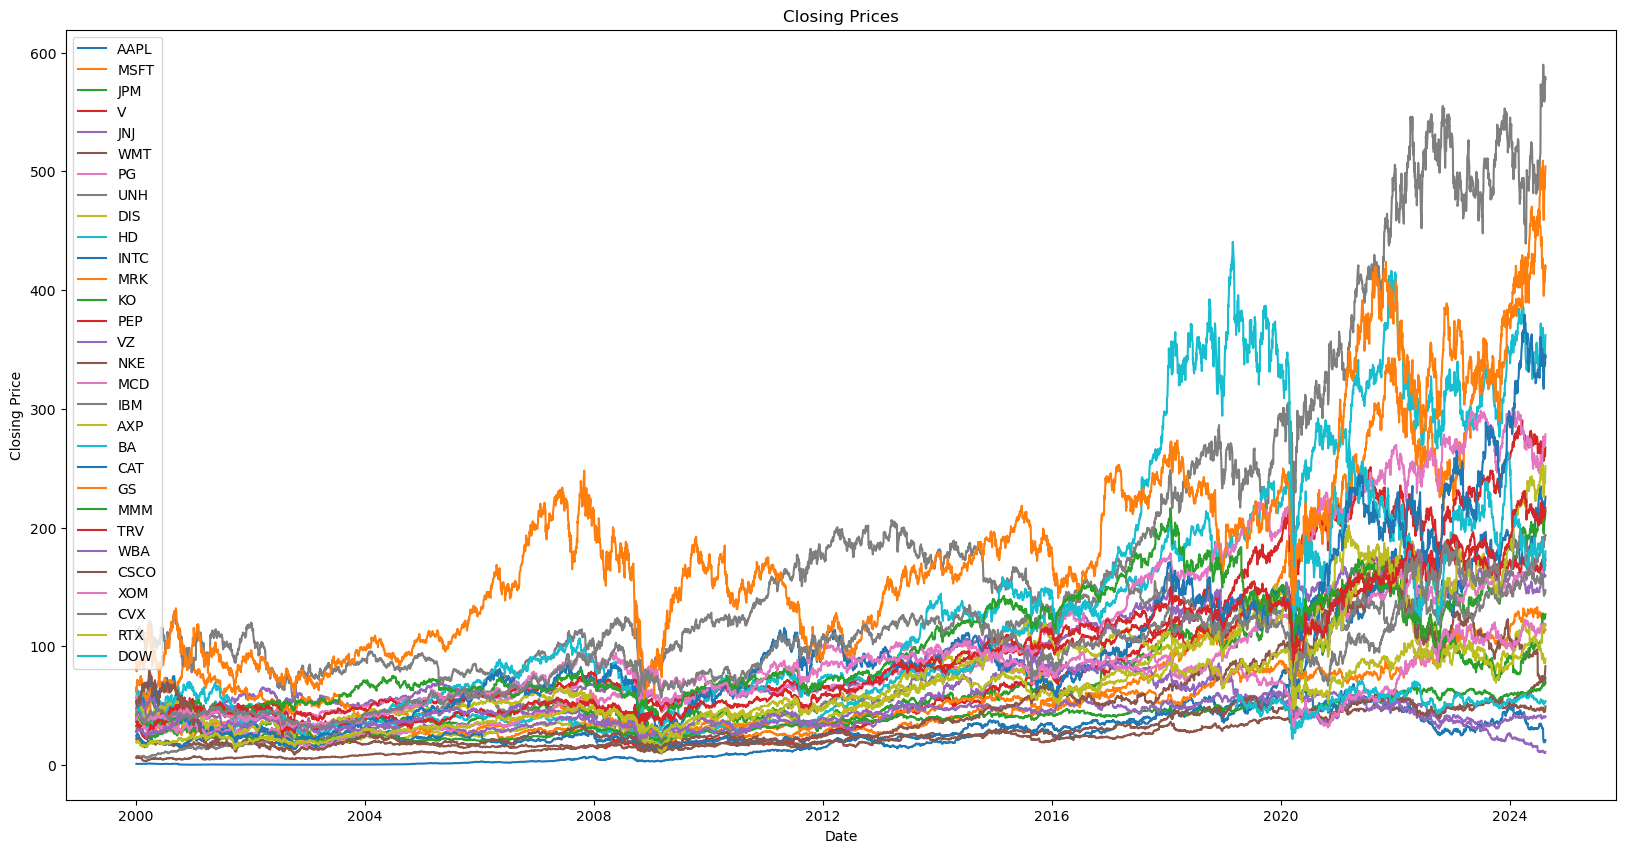

In [1319]:
# plot closing prices
plt.figure(figsize=(20, 10))
for ticker in tickers:
    plt.plot(data[data['Ticker'] == ticker]['Close'], label=ticker)

plt.title('Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [1321]:
# calculate momentum signals

def calculate_returns(group):
    group = group.sort_index()
    group = group.reset_index()
    
    # 3 month returns
    group['Date_3M'] = group['Date'] + pd.DateOffset(months=-3)  # time t-3
    merged_3m = group.merge(group[['Date', 'Close']], left_on='Date_3M', right_on='Date', suffixes=('', '_3M'))
    merged_3m['3M Returns'] = merged_3m['Close'] / merged_3m['Close_3M'] - 1
    
    # 6 month returns
    merged_3m['Date_6M'] = merged_3m['Date'] + pd.DateOffset(months=-6) # time t-6
    merged_6m = merged_3m.merge(group[['Date', 'Close']], left_on='Date_6M', right_on='Date', suffixes=('', '_6M'))
    merged_6m['6M Returns'] = merged_6m['Close'] / merged_6m['Close_6M'] - 1
    
    # 12 month returns
    merged_6m['Date_12M'] = merged_6m['Date'] + pd.DateOffset(months=-12) # time t-12
    merged_12m = merged_6m.merge(group[['Date', 'Close']], left_on='Date_12M', right_on='Date', suffixes=('', '_12M'))
    merged_12m['12M Returns'] = merged_12m['Close'] / merged_12m['Close_12M'] - 1
    
    # 11 month returns (t-12 to t-1)
    merged_12m['Date_1M'] = merged_12m['Date'] + pd.DateOffset(months=-1) # time t-1
    merged_1m = merged_12m.merge(group[['Date', 'Close']], left_on='Date_1M', right_on='Date', suffixes=('', '_1M'))
    merged_1m['11M Returns'] = merged_1m['Close_1M'] / merged_1m['Close_12M'] - 1
    
    # 5 month returns (t-6 to t-1)
    merged_1m['Date_5M'] = merged_1m['Date'] + pd.DateOffset(months=-5)
    merged_5m = merged_1m.merge(group[['Date', 'Close']], left_on='Date_5M', right_on='Date', suffixes=('', '_5M'))
    merged_5m['5M Returns'] = merged_5m['Close_1M'] / merged_5m['Close_6M'] - 1
    
    # drop unnecessary columns
    merged_5m = merged_5m.drop(columns=['Date_3M', 'Date_3M', 'Close_3M', 'Date_6M', 'Date_6M', 'Close_6M', 'Date_12M', 'Date_12M', 'Close_12M', 'Date_1M', 'Date_1M', 'Close_1M', 'Date_5M', 'Date_5M', 'Close_5M'])
    
    merged_5m.set_index('Date', inplace=True)
    
    return merged_5m

In [1323]:
data = data.groupby('Ticker').apply(calculate_returns)

In [1325]:
momentum_signals = data[['3M Returns', '6M Returns', '12M Returns', '11M Returns', '5M Returns']]

In [1327]:
print(momentum_signals.head())

                   3M Returns  6M Returns  12M Returns  11M Returns  \
Ticker Date                                                           
AAPL   2001-01-11   -0.082800   -0.683863    -0.611859    -0.672507   
       2001-01-18   -0.071430   -0.673581    -0.640409    -0.725797   
       2001-02-08    0.034269   -0.556149    -0.638738    -0.711643   
       2001-02-22    0.016894   -0.636033    -0.669412    -0.661724   
       2001-03-06    0.502187   -0.632085    -0.657881    -0.663849   

                   5M Returns  
Ticker Date                    
AAPL   2001-01-11   -0.733260  
       2001-01-18   -0.751092  
       2001-02-08   -0.645722  
       2001-02-22   -0.627569  
       2001-03-06   -0.638503  


In [1329]:
momentum_signals.to_csv('momentum_signals.csv')

In [1331]:
momentum_signals = pd.read_csv('momentum_signals.csv')

In [1333]:
# summary stats: mean, std, min, 25%, 50%, 75%, max, n
summary_stats = momentum_signals.describe()
print(summary_stats)

         3M Returns    6M Returns   12M Returns   11M Returns    5M Returns
count  28457.000000  28457.000000  28457.000000  28457.000000  28457.000000
mean       0.024626      0.045298      0.097166      0.089014      0.037645
std        0.125065      0.181680      0.267526      0.251062      0.161485
min       -0.691877     -0.736316     -0.803882     -0.771703     -0.751092
25%       -0.045997     -0.056612     -0.055106     -0.054875     -0.054109
50%        0.024575      0.042846      0.082152      0.073919      0.036502
75%        0.095835      0.142875      0.230705      0.216325      0.126356
max        1.415295      1.815920      2.977189      2.528195      1.511650


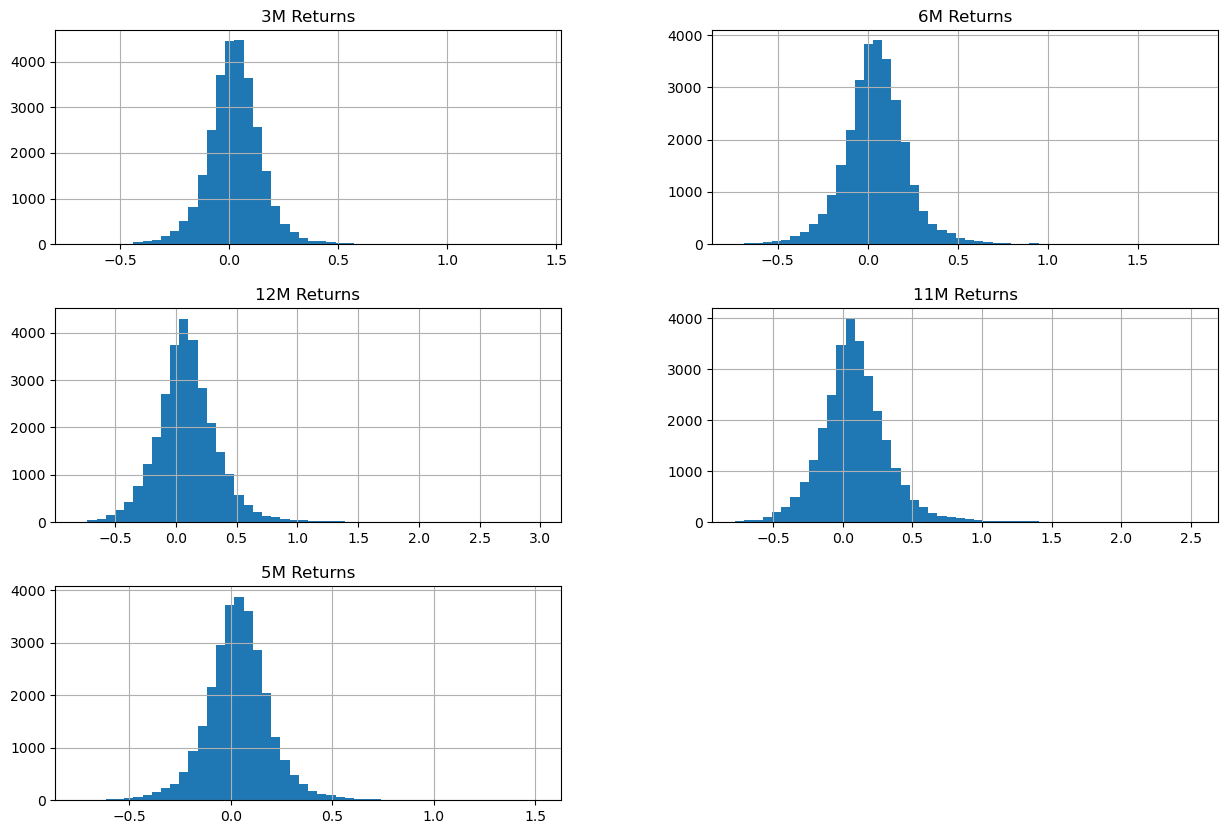

In [1335]:
# histogram for each momentum signal
momentum_signals[['3M Returns', '6M Returns', '12M Returns', '11M Returns', '5M Returns']].hist(bins=50, figsize=(15, 10))
plt.show()

In [1337]:
momentum_signals = momentum_signals.sort_values(['Ticker', 'Date'])

# calculate returns for the future periods. used day approximations for shifts
momentum_signals['3M Future Returns'] = momentum_signals.groupby('Ticker')['3M Returns'].shift(-63)
momentum_signals['6M Future Returns'] = momentum_signals.groupby('Ticker')['6M Returns'].shift(-126)
momentum_signals['12M Future Returns'] = momentum_signals.groupby('Ticker')['12M Returns'].shift(-252)

In [1339]:
# this line gets rid of all dates after august 2018. fix
momentum_signals = momentum_signals.dropna()

In [1347]:
# Run regression
# independent variables momentum signals
X = momentum_signals[['3M Returns', '6M Returns', '12M Returns', '11M Returns', '5M Returns']]

def run_regression(future_return):
    y = momentum_signals[future_return]
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(f'{future_return}:')
    print(model.summary())
    return model

models = {}
for future_return in ['3M Future Returns', '6M Future Returns', '12M Future Returns']:
    models[future_return] = run_regression(future_return)

3M Future Returns:
                            OLS Regression Results                            
Dep. Variable:      3M Future Returns   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     32.72
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           2.30e-33
Time:                        22:23:47   Log-Likelihood:                 15046.
No. Observations:               20972   AIC:                        -3.008e+04
Df Residuals:                   20966   BIC:                        -3.003e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0308      0.0

In [1353]:
# group stocks and analyze portfolio performance:

def calculate_terciles(data, column):
    terciles = pd.qcut(data[column], q=3, labels=['Bottom 3rd', 'Middle 3rd', 'Top 3rd'])
    return terciles

for signal in ['3M Returns', '6M Returns', '12M Returns', '11M Returns', '5M Returns']:
    momentum_signals[f'{signal} Tercile'] = calculate_terciles(momentum_signals, signal)

# portfolio_performance = {}
# for future_return in ['3M Future Returns', '6M Future Returns', '12M Future Returns']:
#     for signal in ['3M Returns', '6M Returns', '12M Returns', '11M Returns', '5M Returns']:
#         grouped = momentum_signals.groupby(f'{signal} Tercile')[future_return].mean()
#         portfolio_performance[f'{signal} - {future_return}'] = grouped

# portfolio_performance_df = pd.DataFrame(portfolio_performance)
# print("Portfolio Performance:")
# print(portfolio_performance_df)

In [1363]:
class MomentumStrategy:
    def __init__(self, momentum_signals, signal_column, return_column):
        self.momentum_signals = momentum_signals
        self.signal_column = signal_column
        self.return_column = return_column
        # self.weights = weights
        
    def calculate_momentum_groups(self):
        self.momentum_signals['Signal_Rank'] = self.momentum_signals.groupby('Date')[self.signal_column].rank(ascending=False)
        
        def assign_groups(x):
            return pd.cut(x.rank(method='first'), bins=3, labels=np.arange(1, 4))

        self.momentum_signals['Momentum_Group'] = self.momentum_signals.groupby('Date')['Signal_Rank'].transform(assign_groups)
        
    def get_strategy_returns(self, top_group=1):
        top_stocks = momentum_signals[momentum_signals['Momentum_Group'] == top_group]
    
        top_stocks.loc[:, 'Weights'] = top_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1/len(x))
       
        top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']
        
        strategy_returns = top_stocks.groupby('Date')['Weighted_Returns'].sum()
        
        return strategy_returns

    ###
    def run_strategy(self):
        self.calculate_momentum_groups()
        strategy_returns = self.get_strategy_returns()
        return strategy_returns

In [1361]:
return_stream = pd.Series(MomentumStrategy(momentum_signals, '3M Returns', '3M Future Returns').run_strategy())
print(return_stream)

Date
2001-01-11   -0.063163
2001-01-18   -0.071213
2001-02-08    0.102171
2001-02-22   -0.000185
2001-03-06   -0.007794
                ...   
2018-07-12    0.064796
2018-07-26    0.086890
2018-08-02    0.070490
2018-08-09    0.096522
2018-08-16    0.092885
Name: Weighted_Returns, Length: 735, dtype: float64


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/2967640197.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weights'] = top_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1/len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/2967640197.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']


In [1365]:
# 11

from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates

def performance_statistics(return_stream):
    #11a: plot index

    index_series = 1000 * (1+return_stream).cumprod()
    index_series.index = pd.to_datetime(index_series.index)

    plt.figure(figsize=(12, 6))
    plt.plot(index_series, label='Investment Index')
    plt.title('Investment Index Over Time')
    plt.xlabel('Date')
    plt.ylabel('Index Value ($)')
    plt.legend()
    plt.grid(True)
    plt.xticks(pd.date_range(start=index_series.index.min(), end=index_series.index.max(), freq='Y'))
    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.show()
    
    
    #11b: annualized mean return
    annualized_mean_return = ((1+return_stream.mean())**252 - 1)
    print(f'Mean return (annualized): {annualized_mean_return:%}')
    
    #11c: annualized volatility
    ############ Is this how you calculate annualized volatility????????????///
    annualized_volatility = return_stream.std() * np.sqrt(252)
    print(f'Volatility (annualized): {annualized_volatility:%}')
    
    #11d: Sharpe ratio
    print(f'Sharpe ratio: {annualized_mean_return / annualized_volatility}')
    
    #11e: hit rate
    hit_rate = (return_stream > 0).mean()
    print(f'Hit rate: {hit_rate:%}')
    
    #11f: max drawdown
    drawdown = ((return_stream).cumprod()) / (return_stream.cumprod().cummax())
    print(f'Max drawdown: {drawdown.max()}')
    
    #11g: highest monthly gain annualized
    annualized_highest_gain = (1 + return_stream.max())** 12 - 1
    print(f'Highest monthly gain (annualized): {annualized_highest_gain:%}')

    #11h: worst monthly loss annualized
    annualized_worst_loss = (1 + return_stream.min())** 12 - 1
    print(f'Worst monthly loss (annualized): {annualized_worst_loss:%}')
    
    #11i: turnover
    
    #11j: return skewness, return kurtosis
    return_skewness = skew(return_stream)
    print(f'Return skewness: {return_skewness}')
    return_kurtosis = kurtosis(return_stream)
    print(f'Return kurtosis: {return_kurtosis}')

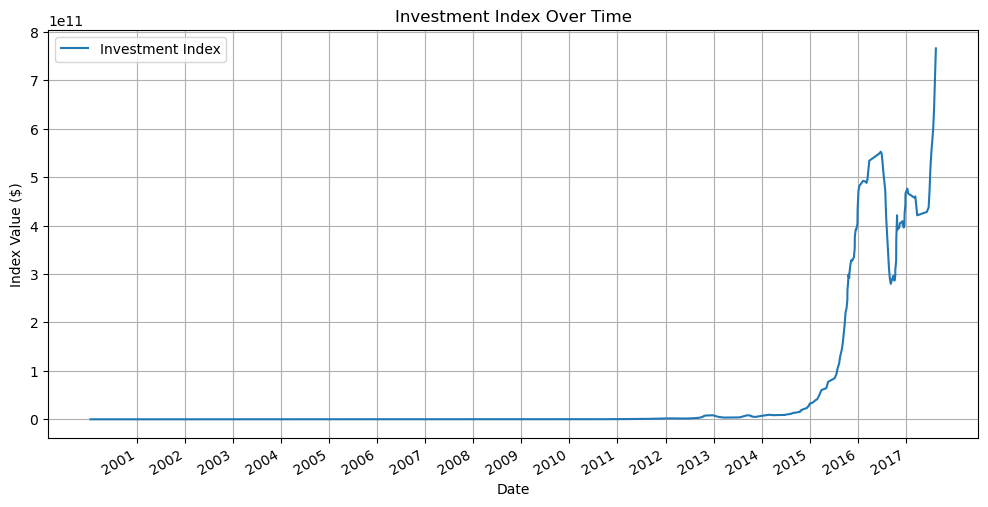

Mean return (annualized): 239525.127576%
Volatility (annualized): 123.722881%
Sharpe ratio: 1935.9808400994223
Hit rate: 72.380952%
Max drawdown: 1.0
Highest monthly gain (annualized): 3293.250019%
Worst monthly loss (annualized): -99.624654%
Return skewness: -0.9599982217742729
Return kurtosis: 2.9047504717092156


In [1367]:
performance_statistics(return_stream)

In [1369]:
#12
# edited class MomentumStrategy:

class MomentumStrategy:
    def __init__(self, momentum_signals, signal_column, return_column, allocation='equal'):
        self.momentum_signals = momentum_signals
        self.signal_column = signal_column
        self.return_column = return_column
        self.allocation = allocation
        
    def calculate_momentum_groups(self):
        self.momentum_signals['Signal_Rank'] = self.momentum_signals.groupby('Date')[self.signal_column].rank(ascending=False)
        
        def assign_groups(x):
            return pd.cut(x.rank(method='first'), bins=3, labels=np.arange(1, 4))

        self.momentum_signals['Momentum_Group'] = self.momentum_signals.groupby('Date')['Signal_Rank'].transform(assign_groups)
        
    # 12d: long only vs long-short
    def best_group(self): # long-only strategy buying only top group. returns returns

        top_stocks = momentum_signals[momentum_signals['Momentum_Group'] == 1]
    
        # 12b: choice of portfolio allocation (I set default to equal weighting)
        if self.allocation == 'equal':
            top_stocks['Weights'] = top_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
        
        elif self.allocation == 'rank':
            top_stocks['Weights'] = top_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: x / x.sum())

        elif self.allocation == 'value':
            top_stocks['Weights'] = top_stocks.groupby('Date')['Market_Cap'].transform(lambda x: x / x.sum())

        else:
            return "Enter allocation method: 'equal', 'rank', or 'value'"
            
        top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']
        
        strategy_returns = top_stocks.groupby('Date')['Weighted_Returns'].sum()
        
        return strategy_returns
    
    def worst_group(self): # long-only strategy buying only worst group
        bottom_stocks = self.momentum_signals[self.momentum_signals['Momentum_Group'] == 3]
        
        if self.allocation == 'equal':
            bottom_stocks['Weights'] = bottom_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
        
        elif self.allocation == 'rank':
            bottom_stocks['Weights'] = bottom_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: x / x.sum())

        elif self.allocation == 'value':
            bottom_stocks['Weights'] = bottom_stocks.groupby('Date')['Market_Cap'].transform(lambda x: x / x.sum())

        bottom_stocks['Weighted_Returns'] = bottom_stocks[self.return_column] * bottom_stocks['Weights']
        
        strategy_returns = bottom_stocks.groupby('Date')['Weighted_Returns'].sum()

        return strategy_returns
    
    def long_short(self):
        return self.best_group() - self.worst_group()
    
    def performance_statistics(return_stream):
        #11a: plot index

        index_series = 1000 * (1+return_stream).cumprod()
        index_series.index = pd.to_datetime(index_series.index)

        plt.figure(figsize=(12, 6))
        plt.plot(index_series, label='Investment Index') # sliced for better readability
        plt.title('Investment Index Over Time')
        plt.xlabel('Date')
        plt.ylabel('Index Value ($)')
        plt.legend()
        plt.grid(True)
        plt.xticks(pd.date_range(start=index_series.index.min(), end=index_series.index.max(), freq='Y'))
        plt.gcf().autofmt_xdate()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.show()


        #11b: annualized mean return
        annualized_mean_return = ((1+return_stream.mean())**252 - 1)
        print(f'Mean return (annualized): {annualized_mean_return:%}')

        #11c: annualized volatility
        ############ Is this how you calculate annualized volatility????????????///
        annualized_volatility = return_stream.std() * np.sqrt(252)
        print(f'Volatility (annualized): {annualized_volatility:%}')

        #11d: Sharpe ratio
        print(f'Sharpe ratio: {annualized_mean_return / annualized_volatility}')

        #11e: hit rate
        ############## 'what percentage of all months are winning months' might not be what's calculated here because of the wack dates in the return stream
        hit_rate = (return_stream > 0).mean()
        print(f'Hit rate: {hit_rate:%}')

        #11f: max drawdown
        drawdown = ((return_stream).cumprod()) / (return_stream.cumprod().cummax())
        print(f'Max drawdown: {drawdown.max()}')

        #11g: highest monthly gain annualized
        annualized_highest_gain = (1 + return_stream.max())** 12 - 1
        print(f'Highest monthly gain (annualized): {annualized_highest_gain:%}')

        #11h: worst monthly loss annualized
        annualized_worst_loss = (1 + return_stream.min())** 12 - 1
        print(f'Worst monthly loss (annualized): {annualized_worst_loss:%}')

        #11i: turnover

        #11j: return skewness, return kurtosis
        return_skewness = skew(return_stream)
        print(f'Return skewness: {return_skewness}')
        return_kurtosis = kurtosis(return_stream)
        print(f'Return kurtosis: {return_kurtosis}')

    def run_strategy(self):
        self.calculate_momentum_groups()
        print(performance_statistics(self.best_group()))
        print(performance_statistics(self.worst_group()))
        print(performance_statistics(self.long_short()))
        return pd.DataFrame({
            'Best Group Returns': self.best_group(),
            'Worst Group Returns': self.worst_group(),
            'Long-Short Returns': self.long_short()
        })

/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Weights'] = top_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']


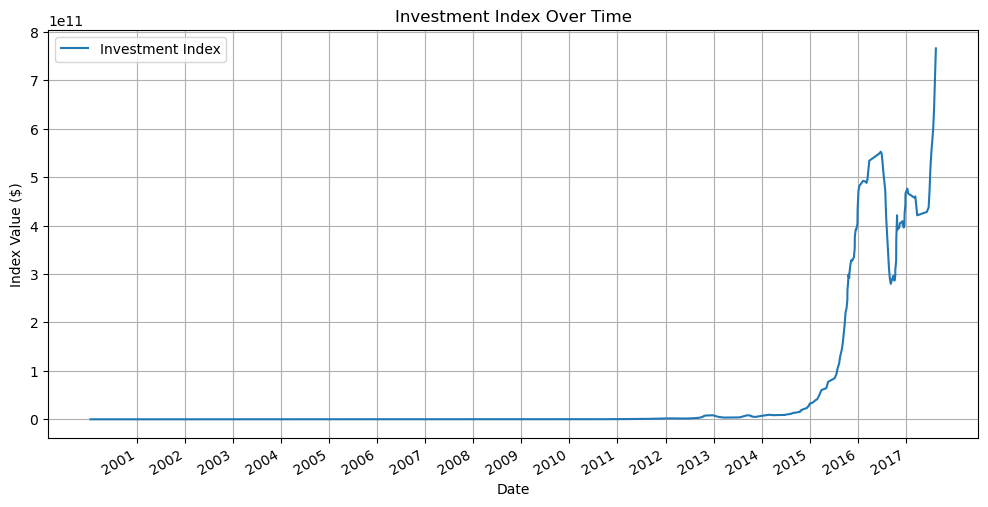

Mean return (annualized): 239525.127576%
Volatility (annualized): 123.722881%
Sharpe ratio: 1935.9808400994223
Hit rate: 72.380952%
Max drawdown: 1.0
Highest monthly gain (annualized): 3293.250019%
Worst monthly loss (annualized): -99.624654%
Return skewness: -0.9599982217742729
Return kurtosis: 2.9047504717092156
None


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_stocks['Weights'] = bottom_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_stocks['Weighted_Returns'] = bottom_stocks[self.return_column] * bottom_stocks['Weights']


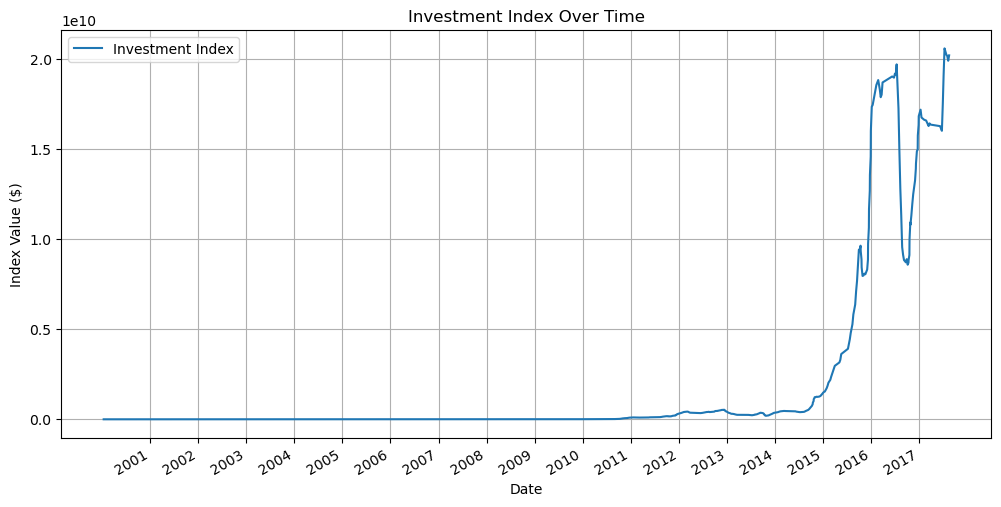

/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Weights'] = top_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_5533

Mean return (annualized): 74081.154240%
Volatility (annualized): 131.697929%
Sharpe ratio: 562.508117029336
Hit rate: 68.571429%
Max drawdown: 1.0
Highest monthly gain (annualized): 23164.334523%
Worst monthly loss (annualized): -99.620066%
Return skewness: 0.029392838255330445
Return kurtosis: 5.004001975302636
None


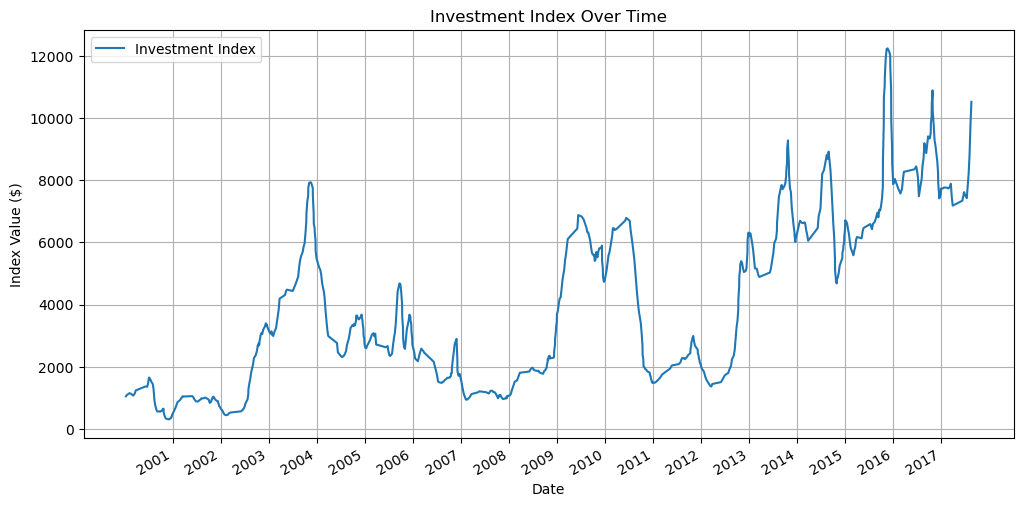

Mean return (annualized): 233.225912%
Volatility (annualized): 88.474166%
Sharpe ratio: 2.6360905459654456
Hit rate: 54.965986%
Max drawdown: 1.0
Highest monthly gain (annualized): 563.746997%
Worst monthly loss (annualized): -98.457290%
Return skewness: -0.44046488143779106
Return kurtosis: 1.8367216076190065
None


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Weights'] = top_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']


            Best Group Returns  Worst Group Returns  Long-Short Returns
Date                                                                   
2001-01-11           -0.063163            -0.107635            0.044472
2001-01-18           -0.071213            -0.110329            0.039116
2001-02-08            0.102171             0.045428            0.056743
2001-02-22           -0.000185             0.025690           -0.025875
2001-03-06           -0.007794             0.036981           -0.044775
...                        ...                  ...                 ...
2018-07-12            0.064796             0.078538           -0.013743
2018-07-26            0.086890            -0.016994            0.103884
2018-08-02            0.070490            -0.003699            0.074189
2018-08-09            0.096522            -0.013038            0.109560
2018-08-16            0.092885             0.015128            0.077757

[735 rows x 3 columns]


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_stocks['Weights'] = bottom_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_stocks['Weighted_Returns'] = bottom_stocks[self.return_column] * bottom_stocks['Weights']
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipyker

In [1371]:
# long vs long_short example

strategy = MomentumStrategy(momentum_signals, '3M Returns', '3M Future Returns', 'equal')
strategy_results = strategy.run_strategy()
print(strategy_results)

In [1373]:
# add market cap column to momentum_signals
djia = pd.read_csv('djia.csv')
djia.set_index(['Ticker', 'Date'], inplace=True)
momentum_signals['Market_Cap'] = momentum_signals.set_index(['Ticker', 'Date']).index.map(djia['Market Cap'])
momentum_signals.reset_index(drop=True, inplace=True)
print(momentum_signals)

      Ticker        Date  3M Returns  6M Returns  12M Returns  11M Returns  \
0       AAPL  2001-01-11   -0.082800   -0.683863    -0.611859    -0.672507   
1       AAPL  2001-01-18   -0.071430   -0.673581    -0.640409    -0.725797   
2       AAPL  2001-02-08    0.034269   -0.556149    -0.638738    -0.711643   
3       AAPL  2001-02-22    0.016894   -0.636033    -0.669412    -0.661724   
4       AAPL  2001-03-06    0.502187   -0.632085    -0.657881    -0.663849   
...      ...         ...         ...         ...          ...          ...   
20967    XOM  2018-07-12    0.070837   -0.055187     0.021369     0.018034   
20968    XOM  2018-07-26    0.041801   -0.053483     0.048152     0.003359   
20969    XOM  2018-08-02    0.040495   -0.054655    -0.008561     0.014392   
20970    XOM  2018-08-09    0.004879    0.059910     0.001371     0.033537   
20971    XOM  2018-08-16   -0.049012    0.019075     0.006841     0.064799   

       5M Returns  3M Future Returns  6M Future Returns  12M Fu

/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Weights'] = top_stocks.groupby('Date')['Market_Cap'].transform(lambda x: x / x.sum())
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']


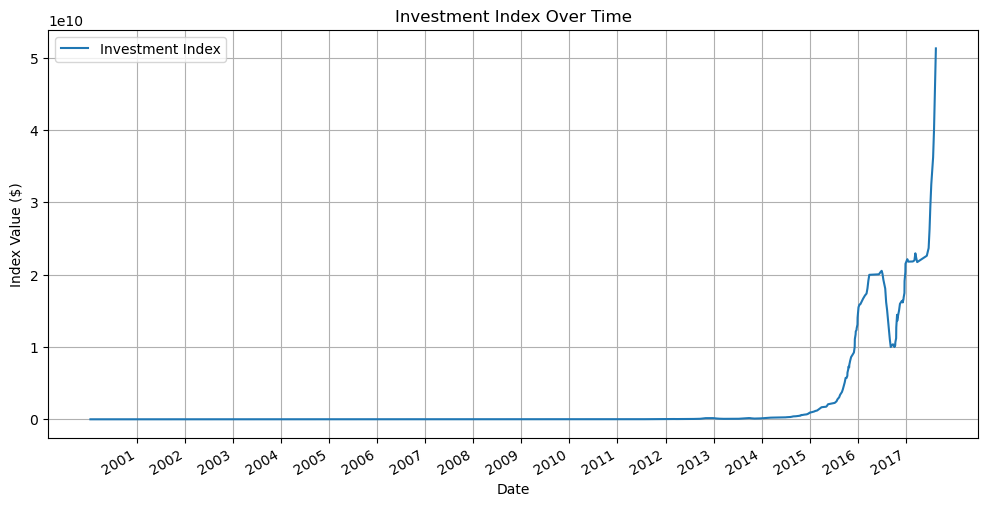

Mean return (annualized): 86608.884602%
Volatility (annualized): 116.550034%
Sharpe ratio: 743.1047541311095
Hit rate: 71.292517%
Max drawdown: 1.0
Highest monthly gain (annualized): 2603.173266%
Worst monthly loss (annualized): -98.533669%
Return skewness: -0.851522299985846
Return kurtosis: 1.9779469450302782
None


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_stocks['Weights'] = bottom_stocks.groupby('Date')['Market_Cap'].transform(lambda x: x / x.sum())
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_stocks['Weighted_Returns'] = bottom_stocks[self.return_column] * bottom_stocks['Weights']


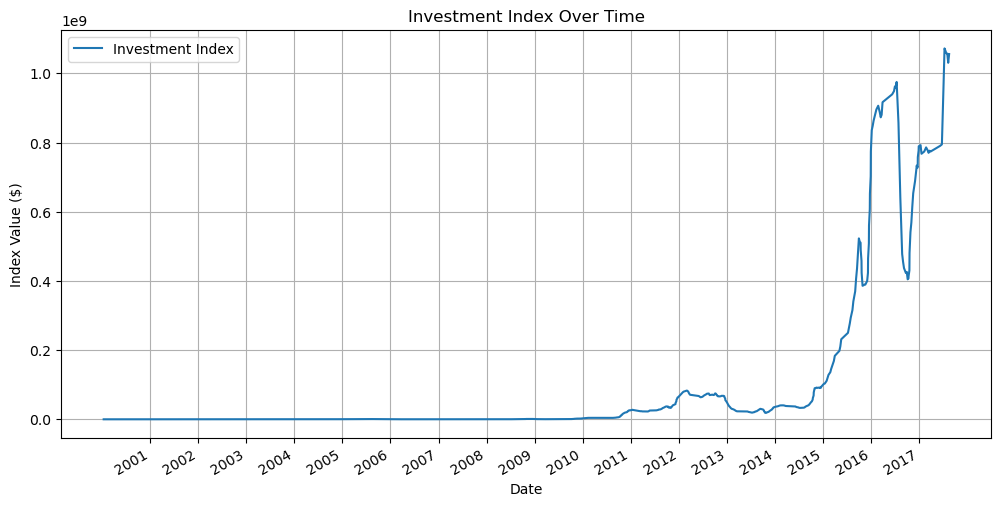

Mean return (annualized): 26183.673612%
Volatility (annualized): 130.369720%
Sharpe ratio: 200.84168006349205
Hit rate: 64.489796%
Max drawdown: 1.0
Highest monthly gain (annualized): 15436.303032%
Worst monthly loss (annualized): -99.306371%
Return skewness: 0.3320993613258418
Return kurtosis: 4.632947794398059
None


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Weights'] = top_stocks.groupby('Date')['Market_Cap'].transform(lambda x: x / x.sum())
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_5533

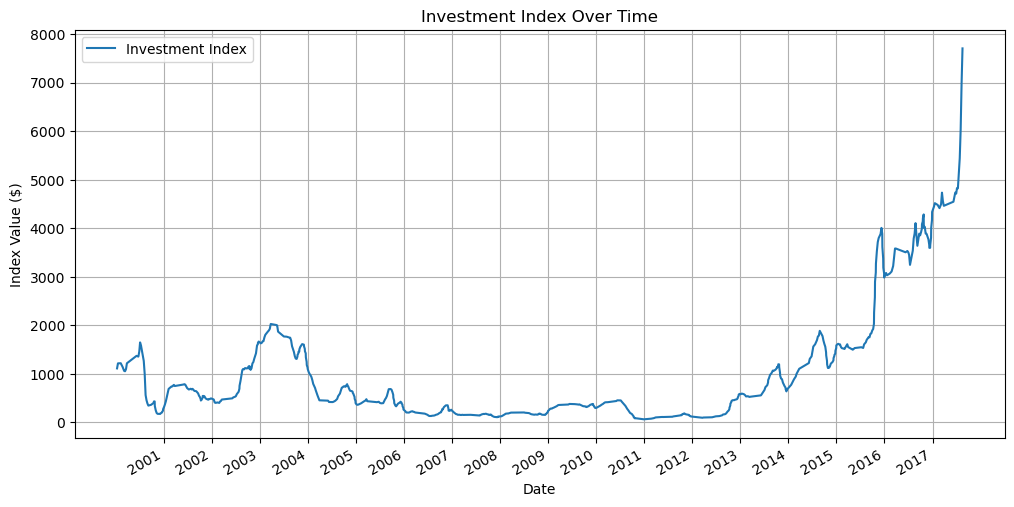

Mean return (annualized): 238.795864%
Volatility (annualized): 100.035740%
Sharpe ratio: 2.3871054875306674
Hit rate: 55.238095%
Max drawdown: 1.0
Highest monthly gain (annualized): 771.817324%
Worst monthly loss (annualized): -99.907485%
Return skewness: -0.7880519114118786
Return kurtosis: 4.073814349648131
None


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Weights'] = top_stocks.groupby('Date')['Market_Cap'].transform(lambda x: x / x.sum())
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_5533

            Best Group Returns  Worst Group Returns  Long-Short Returns
Date                                                                   
2001-01-11           -0.025665            -0.132370            0.106705
2001-01-18           -0.046653            -0.140744            0.094090
2001-02-08            0.118057             0.115873            0.002184
2001-02-22            0.012863             0.074551           -0.061688
2001-03-06            0.006867             0.080534           -0.073667
...                        ...                  ...                 ...
2018-07-12            0.101656             0.102953           -0.001297
2018-07-26            0.116022            -0.013258            0.129281
2018-08-02            0.107298            -0.001049            0.108347
2018-08-09            0.132659            -0.024852            0.157512
2018-08-16            0.128381             0.024469            0.103912

[735 rows x 3 columns]


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Weights'] = top_stocks.groupby('Date')['Market_Cap'].transform(lambda x: x / x.sum())
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_5533

In [1375]:
strategy = MomentumStrategy(momentum_signals, '3M Returns', '3M Future Returns', 'value')
strategy_returns = strategy.run_strategy()
print(strategy_returns)

In [1153]:
# 12c: backtest on momentum signals

print(MomentumStrategy(momentum_signals, '3M Returns', '3M Future Returns').run_strategy())

Date
2001-01-11   -0.063163
2001-01-18   -0.071213
2001-02-08    0.102171
2001-02-22   -0.000185
2001-03-06   -0.007794
                ...   
2018-07-12    0.064796
2018-07-26    0.086890
2018-08-02    0.070490
2018-08-09    0.096522
2018-08-16    0.092885
Name: Weighted_Returns, Length: 735, dtype: float64


In [1155]:
print(MomentumStrategy(momentum_signals, '6M Returns', '6M Future Returns').run_strategy())

Date
2001-01-11    0.223703
2001-01-18    0.173127
2001-02-08    0.148047
2001-02-22    0.147391
2001-03-06    0.103819
                ...   
2018-07-12    0.127797
2018-07-26    0.135201
2018-08-02    0.128705
2018-08-09    0.112891
2018-08-16    0.067544
Name: Weighted_Returns, Length: 735, dtype: float64


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Weights'] = top_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']


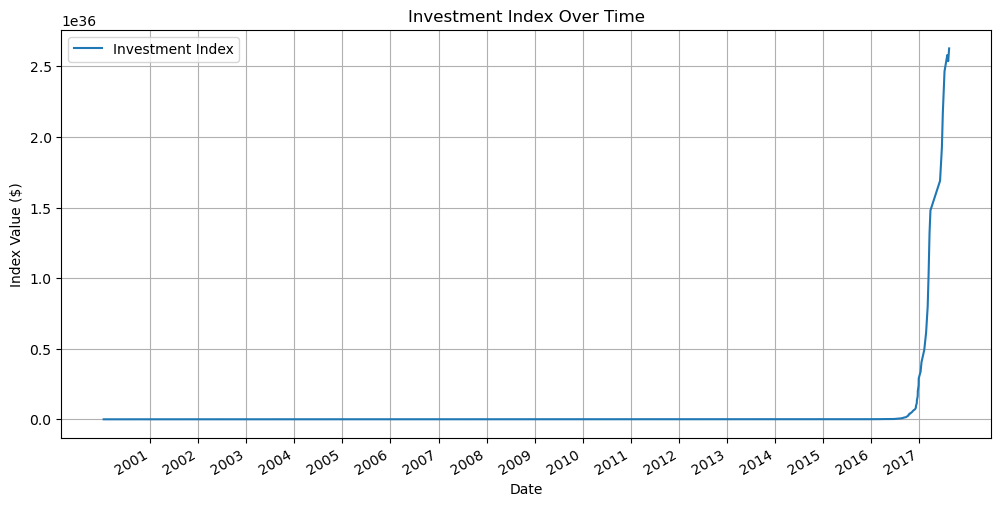

Mean return (annualized): 578839999924436.500000%
Volatility (annualized): 266.831859%
Sharpe ratio: 2169306175014.4246
Hit rate: 83.809524%
Max drawdown: 1.0
Highest monthly gain (annualized): 235262.673658%
Worst monthly loss (annualized): -99.951086%
Return skewness: 0.08685679841164079
Return kurtosis: 3.5444730366727146
None


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_stocks['Weights'] = bottom_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_stocks['Weighted_Returns'] = bottom_stocks[self.return_column] * bottom_stocks['Weights']


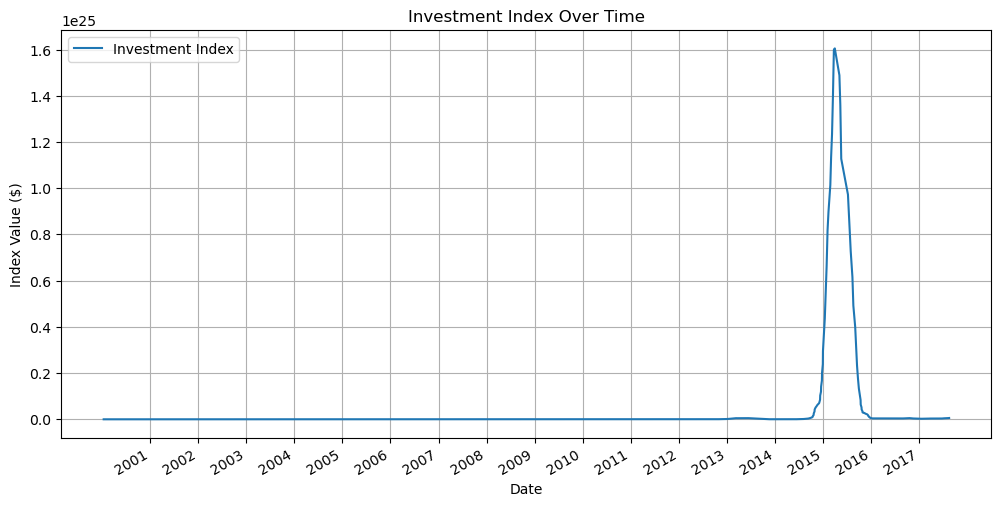

/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Weights'] = top_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_5533

Mean return (annualized): 10916843856.536396%
Volatility (annualized): 252.979396%
Sharpe ratio: 43153094.84754618
Hit rate: 68.979592%
Max drawdown: 1.0
Highest monthly gain (annualized): 30284.670835%
Worst monthly loss (annualized): -99.705122%
Return skewness: -0.1916697616823462
Return kurtosis: 0.1349485169476039
None


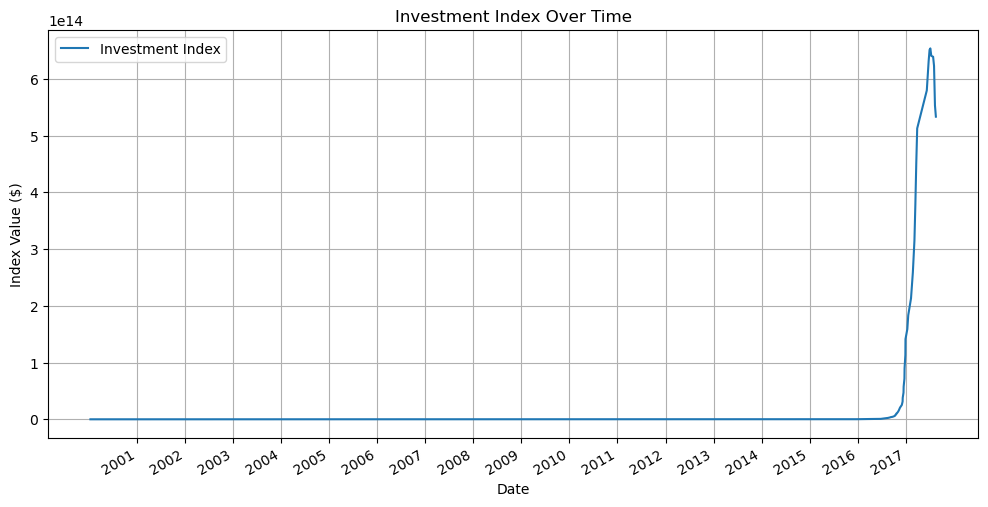

Mean return (annualized): 11920218.383969%
Volatility (annualized): 231.143803%
Sharpe ratio: 51570.57306043273
Hit rate: 59.863946%
Max drawdown: 1.0
Highest monthly gain (annualized): 18877.177118%
Worst monthly loss (annualized): -98.796860%
Return skewness: 0.2937615657734593
Return kurtosis: -0.1054466456010057
None


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Weights'] = top_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks.loc[:, 'Weighted_Returns'] = top_stocks[self.return_column] * top_stocks['Weights']


            Best Group Returns  Worst Group Returns  Long-Short Returns
Date                                                                   
2001-01-11            0.181255             0.155665            0.025590
2001-01-18            0.143409             0.081080            0.062329
2001-02-08            0.113544             0.097379            0.016165
2001-02-22            0.119268             0.127360           -0.008092
2001-03-06            0.112016             0.142907           -0.030892
...                        ...                  ...                 ...
2018-07-12            0.071569             0.091655           -0.020086
2018-07-26            0.032173             0.034701           -0.002528
2018-08-02            0.013878             0.039058           -0.025180
2018-08-09           -0.016705             0.095086           -0.111791
2018-08-16            0.035606             0.071547           -0.035941

[735 rows x 3 columns]


/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_stocks['Weights'] = bottom_stocks.groupby('Date')['Signal_Rank'].transform(lambda x: 1 / len(x))
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipykernel_55335/701522707.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_stocks['Weighted_Returns'] = bottom_stocks[self.return_column] * bottom_stocks['Weights']
/var/folders/vm/7p0bwfw13hg_06st2t0q4pl80000gn/T/ipyker

In [1377]:
print(MomentumStrategy(momentum_signals, '12M Returns', '12M Future Returns').run_strategy())